#                 Microsoft malware prediction Kaggle challenge

### This competition was hosted by Microsoft, Windows Defender ATP Research, Northeastern University College of Computer and Information Science, and Georgia Tech Institute for Information Security & Privacy on kaggle. link: https://www.kaggle.com/c/microsoft-malware-prediction

## Data Description

### The goal of this competition is to predict a Windows machine’s probability of getting infected by various families of malware, based on different properties of that machine. The telemetry data containing these properties and the machine infections was generated by combining heartbeat and threat reports collected by Microsoft's endpoint protection solution, Windows Defender.
### Each row in this dataset corresponds to a machine, uniquely identified by a MachineIdentifier. HasDetections is the ground truth and indicates that Malware was detected on the machine. Using the information and labels in train.csv, you must predict the value for HasDetections for each machine in test.csv.

# Data preprocessing part

In [1]:
 ##### Importing libraries

from fastai.imports import * 
from fastai.structured import *
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [2]:
!ls

fastai	malware_prediction.ipynb  test.csv  train.csv


In [3]:
######   Assigning data types to differnt columns of the given data to reduce the memory usage
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float32',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int16',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float64', 
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float32', 
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float32', 
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float64', 
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float64', 
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float32', 
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float32', 
        'Census_InternalPrimaryDisplayResolutionVertical':      'float32', 
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float64', 
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

In [4]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = [c for c,v in dtypes.items() if v in numerics] #
categorical_columns = [c for c,v in dtypes.items() if v not in numerics] 

retained_columns = numerical_columns + categorical_columns

## Due to large size of dataset which include 78 million rows and 84 columns, and with hardware limitations I use only 5 lakh rows and train my model on these rows.



In [5]:
%time dataset=pd.read_csv('train.csv', nrows=500000, dtype=dtypes, usecols = retained_columns)

CPU times: user 10 s, sys: 264 ms, total: 10.3 s
Wall time: 10.2 s


In [6]:
dataset.head(5)

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0,7.0,0,NaN,53447.0,...,36144.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0
1,000007535c3f730efa9ea0b7ef1bd645,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,0,7.0,0,NaN,53447.0,...,57858.0,0,NaN,0.0,0,0,0.0,0.0,8.0,0
2,000007905a28d863f6d0d597892cd692,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,0,7.0,0,NaN,53447.0,...,52682.0,0,NaN,0.0,0,0,0.0,0.0,3.0,0
3,00000b11598a75ea8ba1beea8459149f,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,0,7.0,0,NaN,53447.0,...,20050.0,0,NaN,0.0,0,0,0.0,0.0,3.0,1
4,000014a5f00daa18e76b81417eeb99fc,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1379.0,0,7.0,0,NaN,53447.0,...,19844.0,0,0.0,0.0,0,0,0.0,0.0,1.0,1


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 83 columns):
MachineIdentifier                                    500000 non-null category
ProductName                                          500000 non-null category
EngineVersion                                        500000 non-null category
AppVersion                                           500000 non-null category
AvSigVersion                                         500000 non-null category
IsBeta                                               500000 non-null int8
RtpStateBitfield                                     498126 non-null float16
IsSxsPassiveMode                                     500000 non-null int8
DefaultBrowsersIdentifier                            24302 non-null float32
AVProductStatesIdentifier                            497969 non-null float32
AVProductsInstalled                                  497969 non-null float16
AVProductsEnabled                           

In [8]:
dataset.shape

(500000, 83)

In [9]:
%time dataset.describe()

CPU times: user 4.51 s, sys: 2 µs, total: 4.51 s
Wall time: 2.36 s


,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
count,500000.000000,498126.0,500000.000000,24302.000000,497969.000000,497969.0,497969.0,500000.000000,500000.000000,481791.000000,...,491044.000000,500000.000000,182927.0,499090.0,500000.000000,500000.000000,496026.0,482909.0,482909.0,500000.000000
mean,0.000010,NaN,0.017286,1652.908569,47866.515625,NaN,NaN,0.987822,107.999314,81303.750000,...,33030.570312,0.486768,0.0,0.0,0.125776,0.037976,0.0,NaN,NaN,0.500768
std,0.003162,0.0,0.130335,996.519836,14006.934570,0.0,0.0,0.109680,62.959880,48925.675781,...,21194.730469,0.499825,0.0,0.0,0.331597,0.191138,0.0,0.0,0.0,0.500000
min,0.000000,0.0,0.000000,1.000000,39.000000,1.0,0.0,0.000000,1.000000,5.000000,...,5.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,1.0,0.000000
25%,0.000000,7.0,0.000000,788.000000,49480.000000,1.0,1.0,1.000000,51.000000,36825.000000,...,13169.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,3.0,0.000000
50%,0.000000,7.0,0.000000,1632.000000,53447.000000,1.0,1.0,1.000000,97.000000,82373.000000,...,33070.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,10.0,1.000000
75%,0.000000,7.0,0.000000,2291.000000,53447.000000,2.0,1.0,1.000000,162.000000,123978.000000,...,52427.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0,1.0,11.0,1.000000
max,1.000000,8.0,1.000000,3204.000000,70492.000000,5.0,4.0,1.000000,222.000000,167962.000000,...,72091.000000,1.000000,0.0,1.0,1.000000,1.000000,1.0,1.0,15.0,1.000000


In [10]:
dataset.head(5)

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0,7.0,0,NaN,53447.0,...,36144.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0
1,000007535c3f730efa9ea0b7ef1bd645,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,0,7.0,0,NaN,53447.0,...,57858.0,0,NaN,0.0,0,0,0.0,0.0,8.0,0
2,000007905a28d863f6d0d597892cd692,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,0,7.0,0,NaN,53447.0,...,52682.0,0,NaN,0.0,0,0,0.0,0.0,3.0,0
3,00000b11598a75ea8ba1beea8459149f,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,0,7.0,0,NaN,53447.0,...,20050.0,0,NaN,0.0,0,0,0.0,0.0,3.0,1
4,000014a5f00daa18e76b81417eeb99fc,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1379.0,0,7.0,0,NaN,53447.0,...,19844.0,0,0.0,0.0,0,0,0.0,0.0,1.0,1


In [11]:
dataset.drop(['MachineIdentifier'], axis=1, inplace=True)

In [12]:
dataset.head()

,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0,7.0,0,NaN,53447.0,1.0,...,36144.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0
1,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,0,7.0,0,NaN,53447.0,1.0,...,57858.0,0,NaN,0.0,0,0,0.0,0.0,8.0,0
2,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,0,7.0,0,NaN,53447.0,1.0,...,52682.0,0,NaN,0.0,0,0,0.0,0.0,3.0,0
3,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,0,7.0,0,NaN,53447.0,1.0,...,20050.0,0,NaN,0.0,0,0,0.0,0.0,3.0,1
4,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1379.0,0,7.0,0,NaN,53447.0,1.0,...,19844.0,0,0.0,0.0,0,0,0.0,0.0,1.0,1


In [13]:
#dataset.fillna(0, inplace=True)
df_trn, y_trn, nas = proc_df(dataset, 'HasDetections', max_n_cat=7)

In [14]:
df_trn.head()

,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,...,Census_ActivationChannel_Volume:MAK,Census_ActivationChannel_nan,Census_FlightRing_Disabled,Census_FlightRing_NOT_SET,Census_FlightRing_RP,Census_FlightRing_Retail,Census_FlightRing_Unknown,Census_FlightRing_WIF,Census_FlightRing_WIS,Census_FlightRing_nan
0,33,28,837,0,7.0,0,1632.0,53447.0,1.0,1.0,...,0,0,0,0,0,1,0,0,0,0
1,23,18,260,0,7.0,0,1632.0,53447.0,1.0,1.0,...,0,0,0,1,0,0,0,0,0,0
2,33,28,715,0,7.0,0,1632.0,53447.0,1.0,1.0,...,0,0,0,0,0,1,0,0,0,0
3,33,28,761,0,7.0,0,1632.0,53447.0,1.0,1.0,...,0,0,0,0,0,1,0,0,0,0
4,33,28,724,0,7.0,0,1632.0,53447.0,1.0,1.0,...,0,0,0,0,0,1,0,0,0,0


In [15]:
y_trn

array([0, 0, 0, ..., 0, 1, 1], dtype=int8)

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_trn, y_trn, test_size = 0.2, random_state = 0)


# Creating a classifier model using Random Forest

In [17]:
set_rf_samples(50000)

In [18]:
Classifier = RandomForestClassifier(n_estimators=200, min_samples_leaf=30, max_features=0.3, n_jobs=-1)
%time Classifier.fit(X_train, y_train)

CPU times: user 5min 18s, sys: 21.2 s, total: 5min 39s
Wall time: 1min 30s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=30, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [19]:
y_pred=Classifier.predict(X_test)

In [20]:
from sklearn.metrics import roc_auc_score

def print_score(m):
    res = [roc_auc_score(y_train, m.predict(X_train)), roc_auc_score(y_test, m.predict(X_test))]
    print(res)

### Printing scores of training set and test set

In [21]:
print_score(Classifier)

[0.6656626231809465, 0.641554871128326]


## Feature importance of columns

In [46]:
fi = rf_feat_importance(Classifier, df_trn); fi[:10]

,cols,imp
26,SmartScreen,0.160805
8,AVProductsInstalled,0.065649
7,AVProductStatesIdentifier,0.059169
2,AvSigVersion,0.056617
0,EngineVersion,0.039137
36,Census_SystemVolumeTotalCapacity,0.034943
12,CityIdentifier,0.031707
34,Census_ProcessorModelIdentifier,0.030555
60,Census_FirmwareVersionIdentifier,0.030064
31,Census_OEMModelIdentifier,0.029870


# Plotting the feature importance

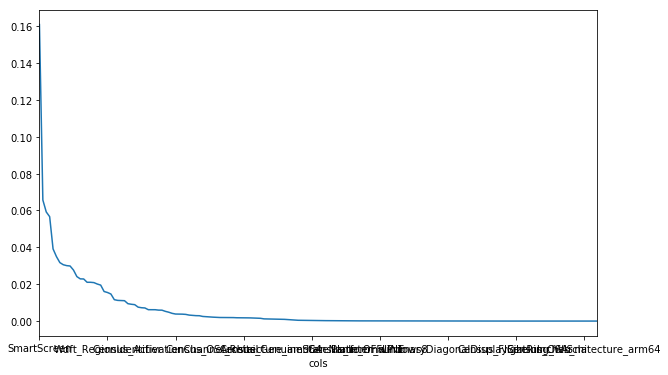

In [47]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

# Plotting bar graph for feature importance

In [48]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,25), legend=False)

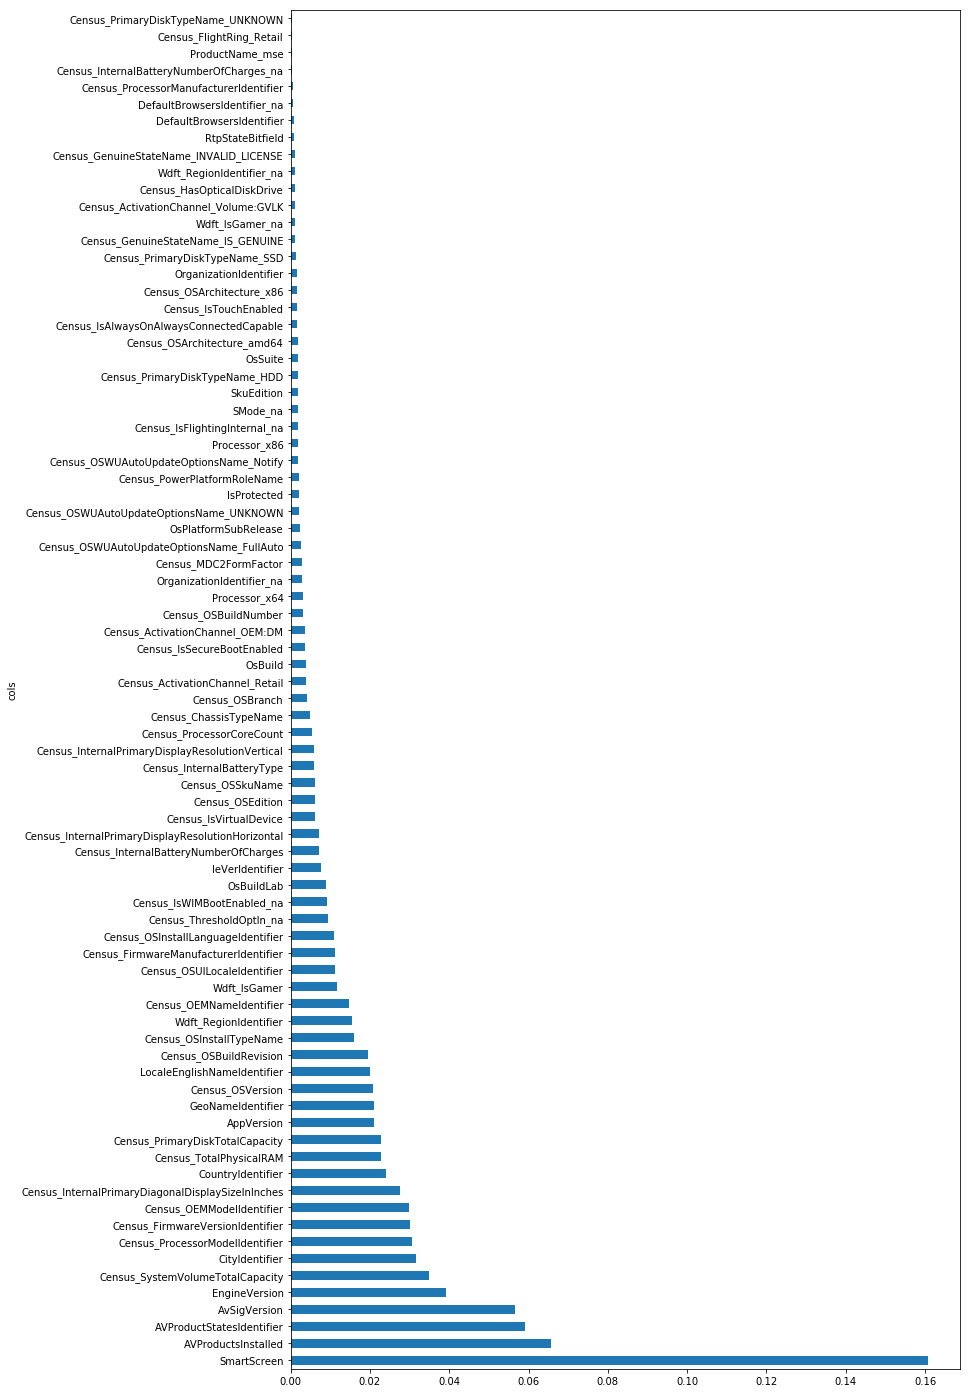

In [49]:
plot_fi(fi[:80]);

## Removing columns with feature importance less that 0.01

In [50]:
to_keep = fi[fi.imp>0.01].cols; len(to_keep)

26

## Creating new test set with new columns

In [51]:
df_keep = df_trn[to_keep].copy()

In [52]:
X_train, X_test, y_train, y_test = train_test_split(df_keep, y_trn, test_size = 0.2, random_state = 0)

In [53]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [54]:
print_score(m)

[0.8138931222959689, 0.687988224757154]


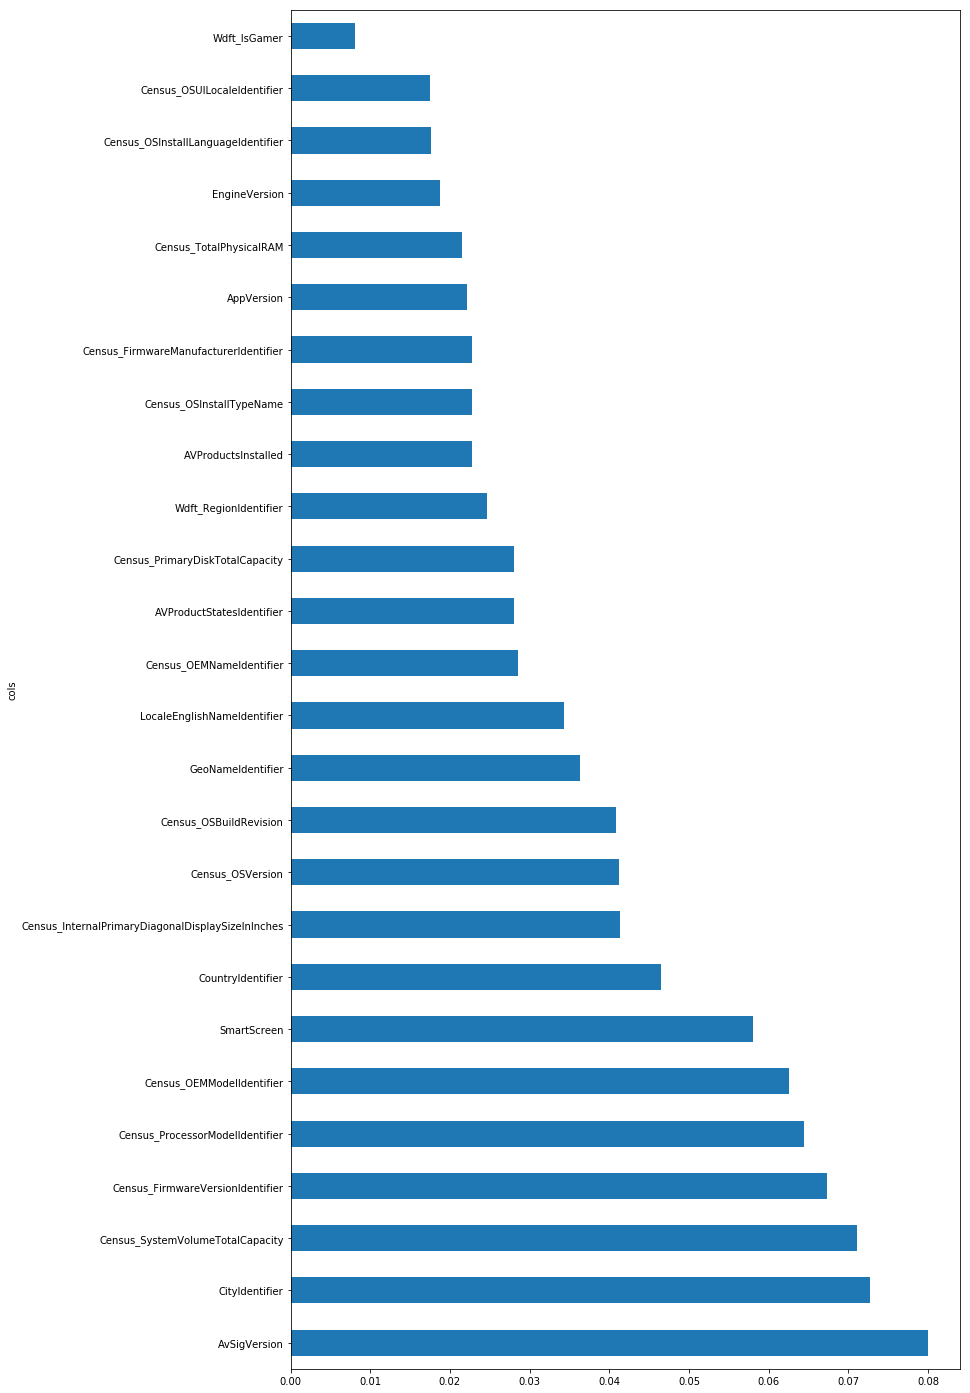

In [55]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

## Thus these are the columns which has significant effect to determine the probability of a device getting infected with malware in near future,